this notebook will be used to show the performance of the second attempt at learning reward.

first load the trained reward network anbd setup methods.

In [1]:
from baselines.common.vec_env import VecFrameStack
from LearningModel.AgentClasses import *
from baselines.common.cmd_util import make_vec_env
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

from os import listdir
from os.path import isfile, join
import re

/home/patrick/PycharmProjects/comp300/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/patrick/PycharmProjects/comp300/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/patrick/PycharmProjects/comp300/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/patrick/PycharmP

In [2]:

#load the reward network
trainedNetwork = RewardNetwork("")

trainedNetwork.load_state_dict(torch.load("/home/patrick/models/breakout-reward2/fullTest.params", map_location=torch.device('cpu')))

#setup the env
model_path = "/home/patrick/models/BreakoutNoFrameskip-v4-demonstrator2"
env_id = 'BreakoutNoFrameskip-v4'
env_type = 'atari'

env = make_vec_env(env_id, env_type, 1, 0,
                   wrapper_kwargs={
                       'clip_rewards': False,
                       'episode_life': False,
                   })
env = VecFrameStack(env, 4)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
agent = PPO2Agent(env, 'atari', True)
trainedNetwork.to(device)

#run the agent in the env once and save the ground truth reward and observations
def GetDemoFromAgent(agent, network, env):
    trueReward = 0
    learnedReward = 0

    currentReward = 0
    currentObservation = env.reset()
    timeSteps = 0
    done = False

    #run the demo
    while True:
        trueReward += currentReward
        shapedObservation = torch.from_numpy(currentObservation).float().to(device)
        reward, abs_reward = network.predict_reward(shapedObservation)
        learnedReward += reward.tolist()

        action = agent.act(currentObservation,  currentReward, done)
        currentObservation, currentReward, done, info = env.step(action)
        shapedObservations = currentObservation
        timeSteps += 1

        if done:
            trueReward += currentReward
            reward, abs_reward = network.predict_reward(shapedObservation)
            learnedReward += reward.tolist()
            break
    print("{}, {}".format(trueReward, learnedReward))
    return trueReward, learnedReward

#a method to find all the models in a given dir that are just numbers
def Find_all_Models(model_dir):

    checkpoints = []
    filesandDirs = listdir(model_dir)
    allFiles = []
    for i in filesandDirs:
        if isfile(join(model_dir, i)):
            allFiles.append(i)

    for file in allFiles:
        if re.match('^[0-9]+$',file.title()):
            checkpoints.append(file.title())

    return checkpoints




Logging to /tmp/openai-2020-03-02-21-01-26-122252





Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use keras.layers.flatten instead.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


now load all models and run each to get demos to run the network on

In [3]:
trueRewards = []
learnedRewards = []

models = Find_all_Models(model_path)

for model in models:
    agent.load(model_path + "/" + model)
    trueReward, learnedReward = GetDemoFromAgent(agent, trainedNetwork, env)
    tf.keras.backend.clear_session()
    trueRewards.append(trueReward[0])
    learnedRewards.append(learnedReward)
    
maxTrue = max(trueRewards)
maxLearned = max(learnedRewards)
normalisedRewards = learnedRewards / (maxLearned / maxTrue)


[296.], 107.2849477417767
[354.], 6.269479243084788
[302.], 29.058241348713636
[386.], 157.6672293888405
[346.], 12.256626955233514
[341.], 7.424159121699631
[370.], -53.22607827465981
[127.], -69.47818772215396
[338.], 6.468784564174712
[391.], -71.2269170274958
[253.], 32.3230883507058
[251.], 69.01550944428891
[278.], 59.052252118475735
[315.], 60.38767535518855
[312.], -43.169355196878314
[384.], 62.31000051833689
[355.], 197.59450798109174
[304.], -36.98946436494589
[197.], 265.2483106730506
[237.], -26.50883644539863
[337.], 47.67021510284394
[379.], -16.397650253027678
[126.], 80.3397380169481
[125.], 44.01650023460388
[227.], 97.9030578294769
[195.], -20.26470302697271
[370.], 90.75793649908155
[115.], -71.49494070373476
[298.], -31.27977804839611
[247.], -22.69222147576511
[262.], -27.15732370968908
[334.], -5.0503228809684515
[98.], -14.677157043479383
[304.], 25.6537814270705
[320.], -42.717179789207876
[323.], 51.83570567611605
[263.], 47.21562774386257
[308.], -45.04158820

In [21]:
maxTrue = max(trueRewards)
minLearned = min(learnedRewards)
normalisedRewards = [x-minLearned for x in learnedRewards]
copyLearned = []
copyTrue = []
for i in range(len(normalisedRewards)):
    if normalisedRewards[i] > 50000 or normalisedRewards[i] <3000:
        pass
    else:
        copyLearned.append(normalisedRewards[i])
        copyTrue.append(trueRewards[i])
minCopy = min(copyLearned)
copyLearned = [x-minCopy for x in copyLearned]
maxLearned = max(copyLearned)
copyLearned = (copyLearned) / (maxLearned / maxTrue)

395.0,-3766.4537807870656


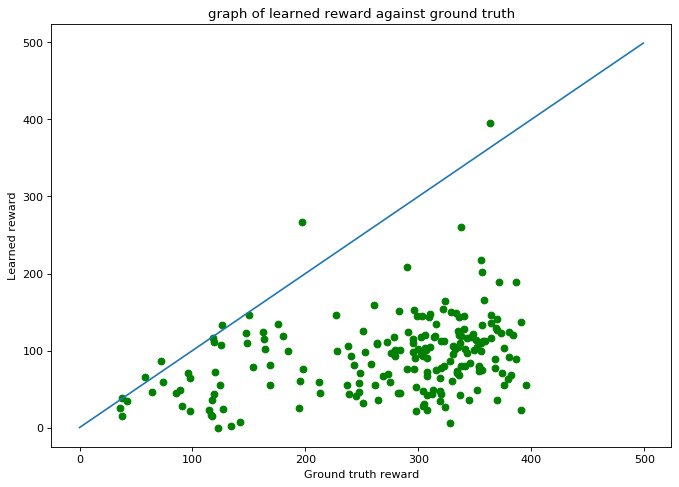

In [24]:
from matplotlib.pyplot import figure

print("{},{}".format(maxTrue, minLearned))

figure(num=None, figsize=(10, 7), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(np.array(copyTrue), np.array(copyLearned), c='g')
plt.plot(np.arange(500), np.arange(500))
plt.ylabel("Learned reward")
plt.xlabel("Ground truth reward")
plt.title("graph of learned reward against ground truth")
plt.show()

In [26]:
minReward = [min(trueRewards)]
maxReward = [max(trueRewards)]
average = [sum(trueRewards) / len(trueRewards)]

from LearningModel.getAverageReward import *
agent.load("~/models/breakout-reward-RL2/breakout_50M_ppo2")
meanR, minR,maxR, std = getAvgReward(agent, env, 20)

minReward.append(minR)
maxReward.append(maxR)
average.append(meanR)


mins: [36.0, 90.0], maxs: [395.0, 374.0], means: [272.52, 256.0]


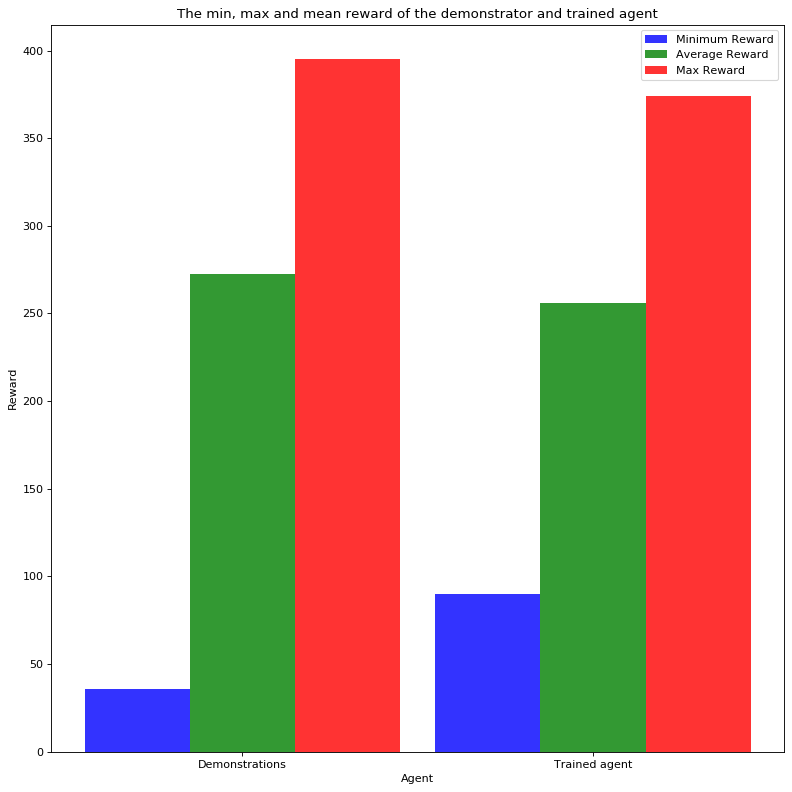

In [27]:
minReward[0] = min(trueRewards)
maxReward[0] = max(trueRewards)
average[0] = sum(trueRewards) /len(trueRewards)
print("mins: {}, maxs: {}, means: {}".format(minReward, maxReward, average))
# create plot
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
#fig, ax = plt.subplots()
index = np.arange(2)
bar_width = 0.3
opacity = 0.8

rects1 = plt.bar(index, minReward, bar_width,
alpha=opacity,
color='b',
label='Minimum Reward')

rects2 = plt.bar(index + bar_width, average, bar_width,
alpha=opacity,
color='g',
label='Average Reward')

rects3 = plt.bar(index + bar_width +bar_width, maxReward, bar_width,
alpha=opacity,
color='r',
label='Max Reward')

plt.xlabel('Agent')
plt.ylabel('Reward')
plt.title('The min, max and mean reward of the demonstrator and trained agent')
plt.xticks(index + bar_width, ('Demonstrations', 'Trained agent'))
plt.legend()

plt.tight_layout()
plt.show()